In [1]:
# run sanitaion_and_fiedler_value.ipynb before running this
import pickle
import numpy as np
from scipy.linalg import eigh
import pandas as pd

In [2]:
def compute_conductance(A_sub, mask1, mask2):
    """
    Compute conductance of a cut defined by mask1 and mask2.
    
    Conductance = cut(S, S') / min(vol(S), vol(S'))
    """
    cut_weight = np.sum(A_sub[np.ix_(mask1, mask2)])
    vol1 = np.sum(A_sub[mask1, :])
    vol2 = np.sum(A_sub[mask2, :])
    min_vol = min(vol1, vol2)
    if min_vol == 0:
        return float('inf')
    return cut_weight / min_vol

# ======================================================
# Recursive Fiedler Segmentation
# ======================================================

def recursive_fiedler(A, nodes=None, normalized=False, lambda2_thresh=None, conductance_thresh=None, verbose=False):
    """
    Minimal recursive Fiedler bisection.
    Stopping rule: λ2 > lambda2_thresh or conductance > conductance_thresh
    """
    if nodes is None:
        nodes = np.arange(A.shape[0])
    nodes = np.asarray(nodes)
    n_nodes = len(nodes)
    
    # Stop trivially small clusters
    if n_nodes <= 2:
        return [nodes]
    
    # Subgraph
    A_sub = A[np.ix_(nodes, nodes)]
    degs = A_sub.sum(axis=1)
    
    # Laplacian
    if not normalized:
        L = np.diag(degs) - A_sub
    else:
        with np.errstate(divide='ignore'):
            inv_sqrt = 1.0 / np.sqrt(degs + 1e-12)
        inv_sqrt[~np.isfinite(inv_sqrt)] = 0.0
        D_inv_sqrt = np.diag(inv_sqrt)
        L = np.eye(n_nodes) - D_inv_sqrt @ A_sub @ D_inv_sqrt
    
    # Eigen decomposition
    vals, vecs = eigh(L)
    lambda2 = vals[1]
    
    if verbose:
        print(f"n={n_nodes} λ2={lambda2:.4f}")
    
    # Stop if λ2 is too large (cluster is tight)
    if lambda2_thresh:
        if lambda2 > lambda2_thresh:
            return [nodes]
    
    # Split by Fiedler sign
    fiedler = vecs[:, 1]
    mask1 = fiedler > 0
    mask2 = fiedler <= 0
    cluster1 = nodes[mask1]
    cluster2 = nodes[mask2]
    
    # Stop if split is trivial
    if len(cluster1) == 0 or len(cluster2) == 0:
        return [nodes]
    
    # Check conductance if threshold provided
    if conductance_thresh:
        conductance = compute_conductance(A_sub, mask1, mask2)
        if verbose:
            print(f"  conductance={conductance:.4f}")
        if conductance > conductance_thresh:
            return [nodes]
    
    # Recurse
    return recursive_fiedler(A, cluster1, normalized, lambda2_thresh, conductance_thresh, verbose) + \
           recursive_fiedler(A, cluster2, normalized, lambda2_thresh, conductance_thresh, verbose)


In [ ]:
with open("samples_by_period.pkl", "rb") as f:
    samples_by_period = pickle.load(f)
with open("corr_by_period.pkl", "rb") as f:
    corr_by_period = pickle.load(f)

clusterings_by_period = {}
for period in samples_by_period.keys():
    corr = corr_by_period[period].values
    samples = samples_by_period[period]
    A = np.abs(corr)
    np.fill_diagonal(A, 0)
    
    # threshold 0.95 is chosen as it is the highest lambda2 observed across periods and is also at a time where market is relatively stable and homogeneous
    # conductance_thresh is set to None to disable conductance based stopping criteria, since it was observed to be too restrictive due to the fact that correlation matrices are dense
    # base conductance is observed to be quite high (>0.5) even for intuitive splits
    clusters = recursive_fiedler(A, normalized=True, lambda2_thresh=0.95, conductance_thresh=None, verbose=False)
    clusterings_by_period[period] = {
        'samples': samples,
        'clusters': clusters
    }

fiedler_value_by_period = {}
for period in samples_by_period.keys():
    corr = corr_by_period[period].values
    A = np.abs(corr)
    np.fill_diagonal(A, 0)
    
    from scipy.sparse import csgraph
    L_norm = csgraph.laplacian(A, normed=True)
    
    # eigenvalues
    eigvals = np.linalg.eigvalsh(L_norm)
    
    # Fiedler value (second-smallest)
    fiedler_value_by_period[period] = eigvals[1]

# # Cluster information
# for period, data in clusterings_by_period.items():
#     samples = data['samples']
#     clusters = data['clusters']
#     print(f"Period: {period}, Number of clusters: {len(clusters)}")
#     for i, cluster in enumerate(clusters):
#         print(f"  Cluster {i+1}: Size {len(cluster)}")

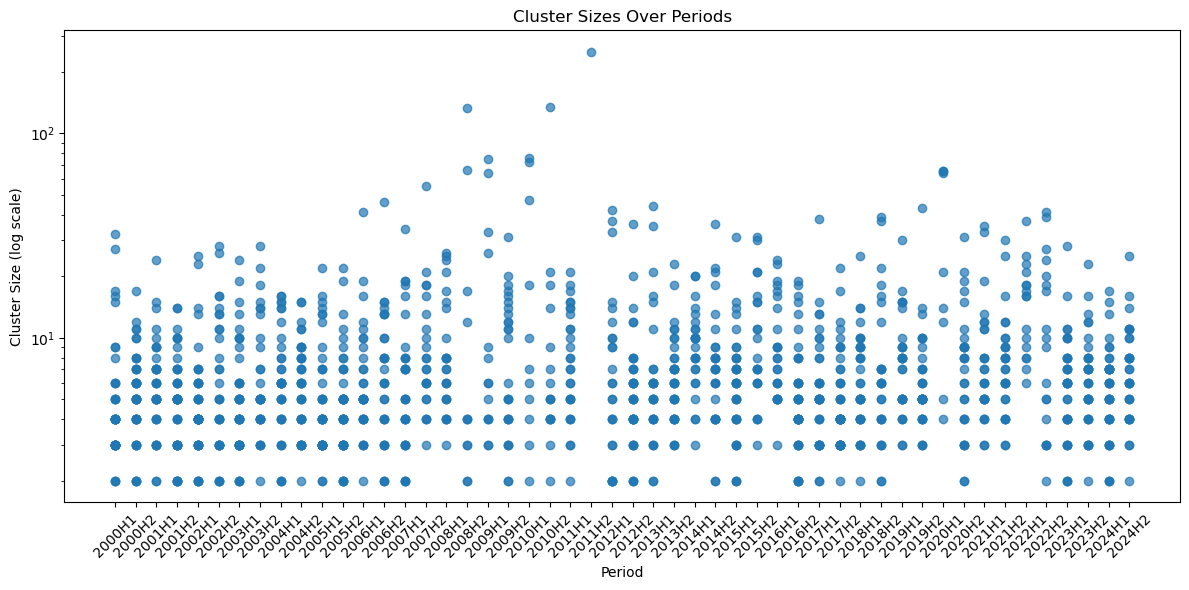

In [4]:
import matplotlib.pyplot as plt

periods = list(clusterings_by_period.keys())

plt.figure(figsize=(12, 6))

for i, period in enumerate(periods):
    sizes = [len(cluster) for cluster in clusterings_by_period[period]['clusters']]
    plt.scatter([i]*len(sizes), sizes, color='C0', alpha=0.7)

plt.yscale('log')  # if cluster sizes vary a lot
plt.xticks(ticks=range(len(periods)), labels=periods, rotation=45)
plt.xlabel('Period')
plt.ylabel('Cluster Size (log scale)')
plt.title('Cluster Sizes Over Periods')
plt.tight_layout()
plt.show()

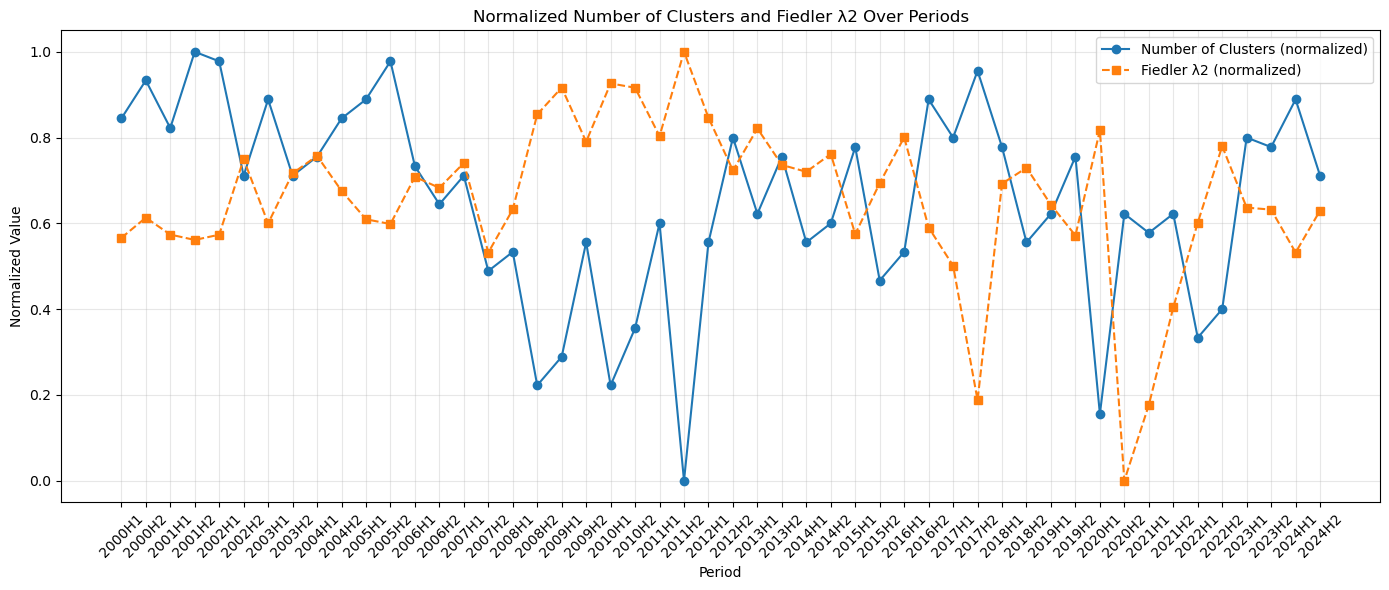

In [5]:

periods = list(clusterings_by_period.keys())
num_clusters = np.array([len(clusterings_by_period[period]['clusters']) for period in periods])
fiedler_values = np.array([fiedler_value_by_period[period] for period in periods])

# Normalize both series to 0-1
num_clusters_norm = (num_clusters - num_clusters.min()) / (num_clusters.max() - num_clusters.min())
fiedler_values_norm = (fiedler_values - fiedler_values.min()) / (fiedler_values.max() - fiedler_values.min())

plt.figure(figsize=(14, 6))
plt.plot(periods, num_clusters_norm, marker='o', linestyle='-', label='Number of Clusters (normalized)')
plt.plot(periods, fiedler_values_norm, marker='s', linestyle='--', label='Fiedler λ2 (normalized)')

plt.xticks(rotation=45)
plt.xlabel('Period')
plt.ylabel('Normalized Value')
plt.title('Normalized Number of Clusters and Fiedler λ2 Over Periods')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [6]:
price_data = pd.read_csv("price_data.csv", low_memory = False)

In [7]:
price_data.head()

,permno,date,ticker,comnam,numtrd,price,market_cap,vol,sic2,period,ret,sector
0,69163,2000-01-03,ACV,ALBERTO CULVER CO,NaN,21.125000,4.800445e+08,6300.0,28.0,2000H1,0.544513,Manufacturing
1,80169,2000-01-03,AGM,FEDERAL AGRICULTURAL MORT CORP,NaN,19.312500,1.800118e+08,4100.0,61.0,2000H1,0.188164,Finance/Insurance/RealEstate
2,77881,2000-01-03,BDG,BANDAG INC,NaN,21.437500,2.311391e+08,3200.0,30.0,2000H1,-0.163684,Manufacturing
3,29946,2000-01-03,BF,BROWN FORMAN CORP,NaN,6.146667,2.277455e+09,1075312.5,20.0,2000H1,0.075368,Manufacturing
4,83443,2000-01-03,BRK,BERKSHIRE HATHAWAY INC DEL,NaN,35.300000,9.428630e+09,873500.0,63.0,2000H1,-7.347563,Finance/Insurance/RealEstate


In [ ]:
rows = []

# convert clustering by period to DataFrame

for period, clustering in clusterings_by_period.items():
    samples = clustering.get("samples", [])
    clusters = clustering.get("clusters", [])
    
    for cluster_id, idx_array in enumerate(clusters):
        for idx in idx_array:
            if idx < len(samples):
                ticker = samples[idx]
                rows.append({
                    "period": period,
                    "ticker": ticker,
                    "cluster": cluster_id
                })
            else:
                print(f"Index {idx} out of range for period {period}")

cluster_map = pd.DataFrame(rows)

cluster_map.head()

,period,ticker,cluster
0,2000H1,CINF,0
1,2000H1,MTIC,0
2,2000H1,TQNT,0
3,2000H1,DKEY,0
4,2000H1,RRRR,0


In [ ]:
# one stock is categorized into 2 clusters for a single period

inconsistent = (
    cluster_map.groupby(["period", "ticker"])["cluster"]
    .nunique()
    .reset_index(name="n_cluster")
    .query("n_cluster > 1")
)
print(inconsistent)

dup_rows = cluster_map.merge(
    inconsistent[["period", "ticker"]], how="inner", on=["period", "ticker"]
)
dup_rows.sort_values(["period", "ticker"])

      period ticker  n_cluster
7633  2015H1   LPNT          2


,period,ticker,cluster
0,2015H1,LPNT,0
1,2015H1,LPNT,24


In [ ]:
# merge clusterings with price data

price_data_with_clusters = price_data.merge(
    cluster_map,
    how="left",
    on=["period", "ticker"]
)

In [17]:
price_data_with_clusters.head()

,permno,date,ticker,comnam,numtrd,price,market_cap,vol,sic2,period,ret,sector,cluster
0,69163,2000-01-03,ACV,ALBERTO CULVER CO,NaN,21.125000,4.800445e+08,6300.0,28.0,2000H1,0.544513,Manufacturing,NaN
1,80169,2000-01-03,AGM,FEDERAL AGRICULTURAL MORT CORP,NaN,19.312500,1.800118e+08,4100.0,61.0,2000H1,0.188164,Finance/Insurance/RealEstate,NaN
2,77881,2000-01-03,BDG,BANDAG INC,NaN,21.437500,2.311391e+08,3200.0,30.0,2000H1,-0.163684,Manufacturing,NaN
3,29946,2000-01-03,BF,BROWN FORMAN CORP,NaN,6.146667,2.277455e+09,1075312.5,20.0,2000H1,0.075368,Manufacturing,NaN
4,83443,2000-01-03,BRK,BERKSHIRE HATHAWAY INC DEL,NaN,35.300000,9.428630e+09,873500.0,63.0,2000H1,-7.347563,Finance/Insurance/RealEstate,NaN


In [18]:
price_data_with_clusters = price_data_with_clusters.dropna(subset=["cluster"])
price_data_with_clusters["cluster"] = price_data_with_clusters["cluster"].astype(int)

print(price_data_with_clusters[["permno", "ticker", "period", "cluster"]].head())
print(price_data_with_clusters["cluster"].isna().mean()) 

     permno ticker  period  cluster
53    84287   AASI  2000H1        6
67    77595   ABFS  2000H1        9
68    86235   ABGX  2000H1        3
86    79366   ACAI  2000H1        0
112   87050   ACRU  2000H1       13
0.0


In [ ]:
df = price_data_with_clusters.copy()
df.shape

,permno,date,ticker,comnam,numtrd,price,market_cap,vol,sic2,period,ret,sector,cluster
53,84287,2000-01-04,AASI,ADVANCED AERODYNAMICS STRUC INC,17.0,3.06250,2.143750e+07,9185.0,37.0,2000H1,-0.020203,Manufacturing,6
67,77595,2000-01-04,ABFS,ARKANSAS BEST CORP DEL,54.0,12.71875,2.513479e+08,37147.0,42.0,2000H1,0.012361,Transp/Comm/Utilities,9
68,86235,2000-01-04,ABGX,ABGENIX INC,688.0,28.00000,1.688624e+09,1253464.0,28.0,2000H1,-0.105807,Manufacturing,3
86,79366,2000-01-04,ACAI,ATLANTIC COAST AIRLINES HLDG INC,121.0,11.00000,4.081220e+08,115446.0,45.0,2000H1,-0.030772,Transp/Comm/Utilities,0
112,87050,2000-01-04,ACRU,ACCRUE SOFTWARE INC,670.0,51.25000,1.005012e+09,148107.0,73.0,2000H1,-0.075153,Services,13


In [20]:
# aggregate covariates to the period level
period_stock = (
    df.groupby(['period', 'permno', 'cluster'])
      .agg(
          sector=('sector', lambda x: x.value_counts().idxmax()),  # dominant sector
          sic2=('sic2', 'max'),
          ret_mean=('ret', 'mean'),
          ret_std=('ret', 'std'),
          vol_mean=('vol', 'mean'),
          market_cap_median=('market_cap', 'median'),
          numtrd_mean=('numtrd', 'mean')
      )
      .reset_index()
)

In [21]:
period_stock.head()

,period,permno,cluster,sector,sic2,ret_mean,ret_std,vol_mean,market_cap_median,numtrd_mean
0,2000H1,10012,1,Manufacturing,36.0,0.002456,0.068159,3.672924e+05,1.445550e+08,434.704
1,2000H1,10200,5,Manufacturing,28.0,0.005747,0.097051,5.074161e+05,1.529618e+08,615.352
2,2000H1,10235,5,Retail Trade,59.0,0.000606,0.075345,2.130237e+05,6.658031e+07,200.856
3,2000H1,10299,3,Manufacturing,36.0,0.004595,0.051161,4.019478e+06,1.586559e+10,4657.216
4,2000H1,10304,6,Finance/Insurance/RealEstate,60.0,-0.001647,0.028587,7.058417e+04,5.403461e+08,76.736


In [ ]:
(
    period_stock.groupby(["period", "permno"])
    .size()
    .reset_index(name="n")
    .query("n > 1")
)

period_stock[(period_stock["period"] == "2015H1") & (period_stock["permno"] == 86899)] # one stock is categorized into 2 clusters for a single period

,period,permno,cluster,sector,sic2,ret_mean,ret_std,vol_mean,market_cap_median,numtrd_mean
7647,2015H1,86899,0,Services,80.0,0.001532,0.016611,365393.41129,3.256055e+09,3676.5
7648,2015H1,86899,24,Services,80.0,0.001532,0.016611,365393.41129,3.256055e+09,3676.5


In [146]:
period_stock["log_mktcap"] = np.log(period_stock["market_cap_median"])
period_stock["log_vol"] = np.log(period_stock["vol_mean"])
period_stock["log_ret_mean"] = np.log(period_stock["ret_mean"])
period_stock["log_ret_std"] = np.log(period_stock["ret_std"])
period_stock["log_numtrd"] = np.log(period_stock["numtrd_mean"])

/opt/anaconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='cluster', ylabel='log_ret_std'>

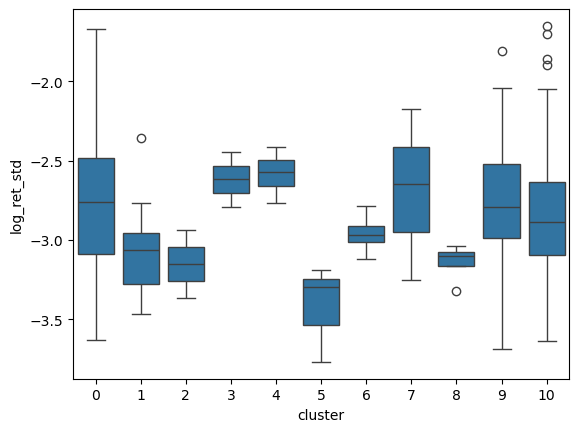

In [67]:
import seaborn as sns
sns.boxplot(x="cluster", y="log_ret_std", data=period_stock[period_stock['period']=="2008H2"])

<Axes: xlabel='cluster', ylabel='log_mktcap'>

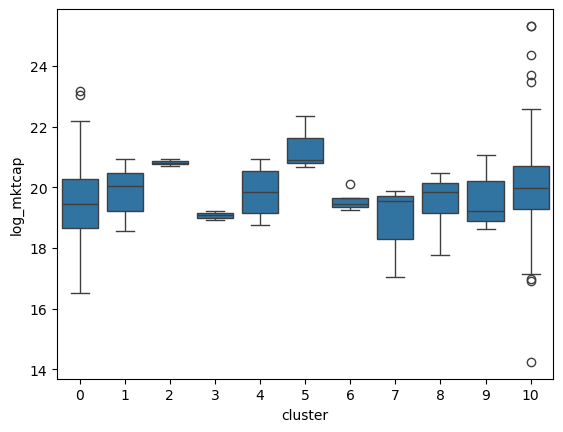

In [82]:
sns.boxplot(x="cluster", y="log_mktcap", data=period_stock[period_stock['period']=="2008H2"])

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.metrics import balanced_accuracy_score

factors_num = ["log_mktcap", "log_ret_std", "log_vol", "log_ret_mean"]
factor_cat = ["sector"]

results = []

for period, df_t in period_stock.groupby("period"):
    X = df_t[factors_num + factor_cat]
    y = df_t["cluster"]

    # skip empty clusters or missing y
    if len(np.unique(y)) <= 1:
        continue
    
    numeric_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median"))
    ])
    categorical_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(drop="first"))
    ])

    preprocessor = ColumnTransformer([
        ("num", numeric_pipeline, factors_num),
        ("cat", categorical_pipeline, factor_cat)
    ])

    logit = LogisticRegression(
        multi_class="multinomial", solver="lbfgs",
        penalty="l2", C=1.0, max_iter=500
    )

    pipe = Pipeline([("preprocess", preprocessor), ("model", logit)])
    pipe.fit(X, y)

    # pseudo-R²
    p = pipe.predict_proba(X)
    LL_model = -log_loss(y, p, normalize=False)
    # LL_null  = -log_loss(y, np.full_like(p, 1/p.shape[1]), normalize=False)
    y_counts = np.bincount(y)
    null_probs = y_counts / len(y)
    LL_null = -log_loss(y, np.tile(null_probs, (len(y), 1)), normalize=False)
    pseudoR2 = 1 - (LL_model / LL_null)

    results.append({"period": period, "pseudoR2_McFadden": pseudoR2})

results_df = pd.DataFrame(results)
print(results_df)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn

    period  pseudoR2_McFadden
0   2000H1           0.136003
1   2000H2           0.141983
2   2001H1           0.134443
3   2001H2           0.159438
4   2002H1           0.146333
5   2002H2           0.125928
6   2003H1           0.153414
7   2003H2           0.143971
8   2004H1           0.142470
9   2004H2           0.143728
10  2005H1           0.133617
11  2005H2           0.143984
12  2006H1           0.123613
13  2006H2           0.122959
14  2007H1           0.105834
15  2007H2           0.096023
16  2008H1           0.100131
17  2008H2           0.101446
18  2009H1           0.088505
19  2009H2           0.112005
20  2010H1           0.066717
21  2010H2           0.112926
22  2011H1           0.128087
23  2012H1           0.108850
24  2012H2           0.143268
25  2013H1           0.126589
26  2013H2           0.142516
27  2014H1           0.109996
28  2014H2           0.120797
29  2015H1           0.137701
30  2015H2           0.126662
31  2016H1           0.109550
32  2016H2

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

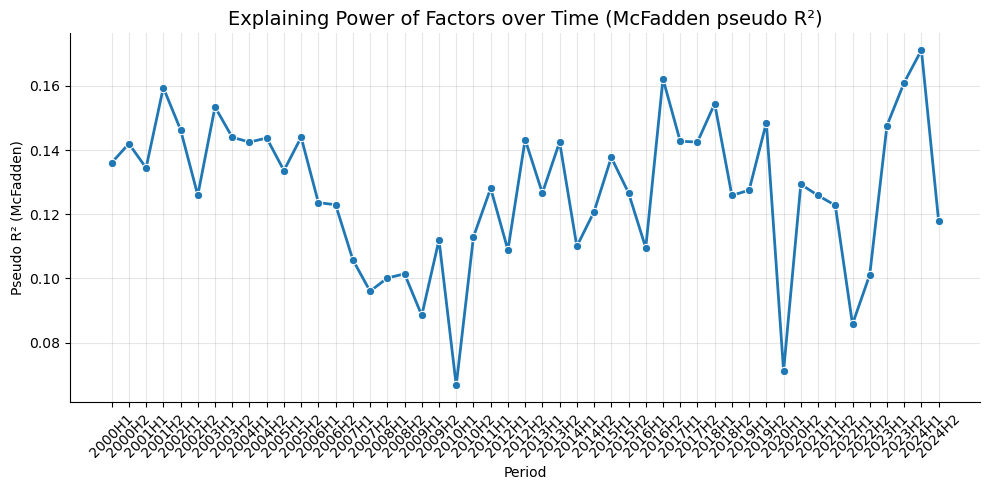

In [ ]:
plt.figure(figsize=(10,5))
sns.lineplot(
    data=results_df.sort_values("period"),
    x="period",
    y="pseudoR2_McFadden",
    marker="o",
    linewidth=2,
    color="tab:blue"
)

plt.title("Explaining Power of Factors over Time (McFadden pseudo R²)", fontsize=14)
plt.xlabel("Period")
plt.ylabel("Pseudo R² (McFadden)")
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
sns.despine()
plt.tight_layout()
plt.show()

In [ ]:
# Factor group definitions
factor_sets = {
    "mktcap": ["log_mktcap"],
    "ret_std": ["log_ret_std"],
    "sector": ["sector"],
    # "vol": ["log_vol"],
    "all": factors_num + factor_cat
}

def run_multinom(df, factors_num, factor_cat):
    if df["cluster"].nunique() <= 1:
        return np.nan, np.nan  # Return TWO values
    
    numeric_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median"))
    ])
    categorical_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(drop="first"))
    ])
    preprocessor = ColumnTransformer([
        ("num", numeric_pipeline, factors_num),
        ("cat", categorical_pipeline, factor_cat)
    ])
    logit = LogisticRegression(multi_class="multinomial", solver="saga",
                               penalty="l2", C=1.0, max_iter=1000)
    pipe = Pipeline([("preprocess", preprocessor), ("model", logit)])
    X = df[factors_num + factor_cat]
    y = df["cluster"]
    pipe.fit(X, y)
    p = pipe.predict_proba(X)
    LL_model = -log_loss(y, p, normalize=False)
    y_value_counts = pd.Series(y).value_counts(normalize=True).sort_index()
    null_probs = np.tile(y_value_counts.values, (len(y), 1))
    LL_null = -log_loss(y, null_probs, normalize=False)
    y_pred = pipe.predict(X)
    balanced_acc = balanced_accuracy_score(y, y_pred)
    return 1 - (LL_model / LL_null), balanced_acc

# Run for each period and factor set
results = []
for set_name, vars_ in factor_sets.items():
    for period, dfp in period_stock.groupby("period"):
        factors_num = [v for v in vars_ if v.startswith("log_")]
        factors_cat = [v for v in vars_ if v not in factors_num]
        r2, balanced_acc = run_multinom(dfp, factors_num, factors_cat)
        results.append({"period": period, "model": set_name, "pseudoR2": r2, "balanced_acc": balanced_acc})

res_df = pd.DataFrame(results)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max

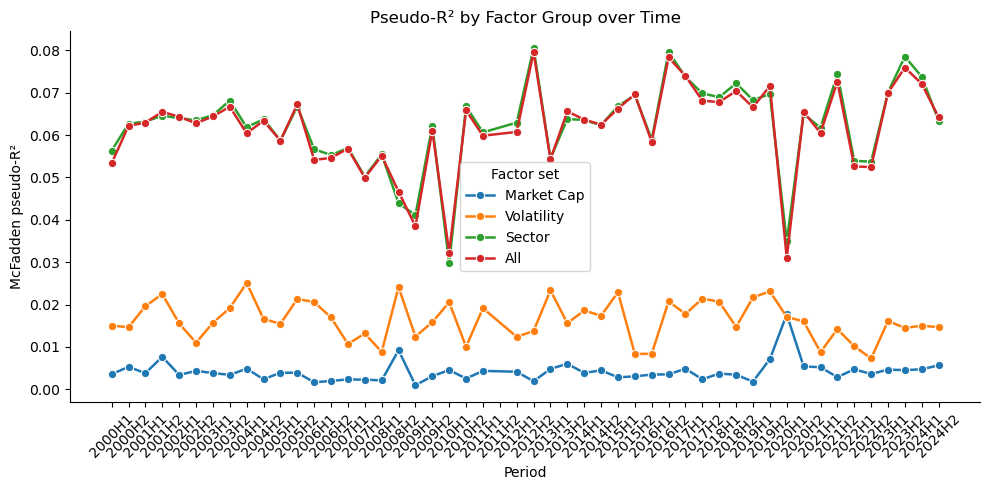

In [148]:
label_map = {
    'mktcap': 'Market Cap',
    'ret_std': 'Volatility',
    'sector': 'Sector',
    'all': 'All'
}
res_df['model'] = res_df['model'].map(label_map)

plt.figure(figsize=(10,5))
sns.lineplot(data=res_df, x="period", y="pseudoR2", hue="model",
             marker="o", linewidth=1.8)
plt.title("Pseudo‑R² by Factor Group over Time")
plt.xticks(rotation=45)
plt.ylabel("McFadden pseudo‑R²")
plt.xlabel("Period")
plt.legend(title="Factor set")
sns.despine()
plt.tight_layout()
plt.show()

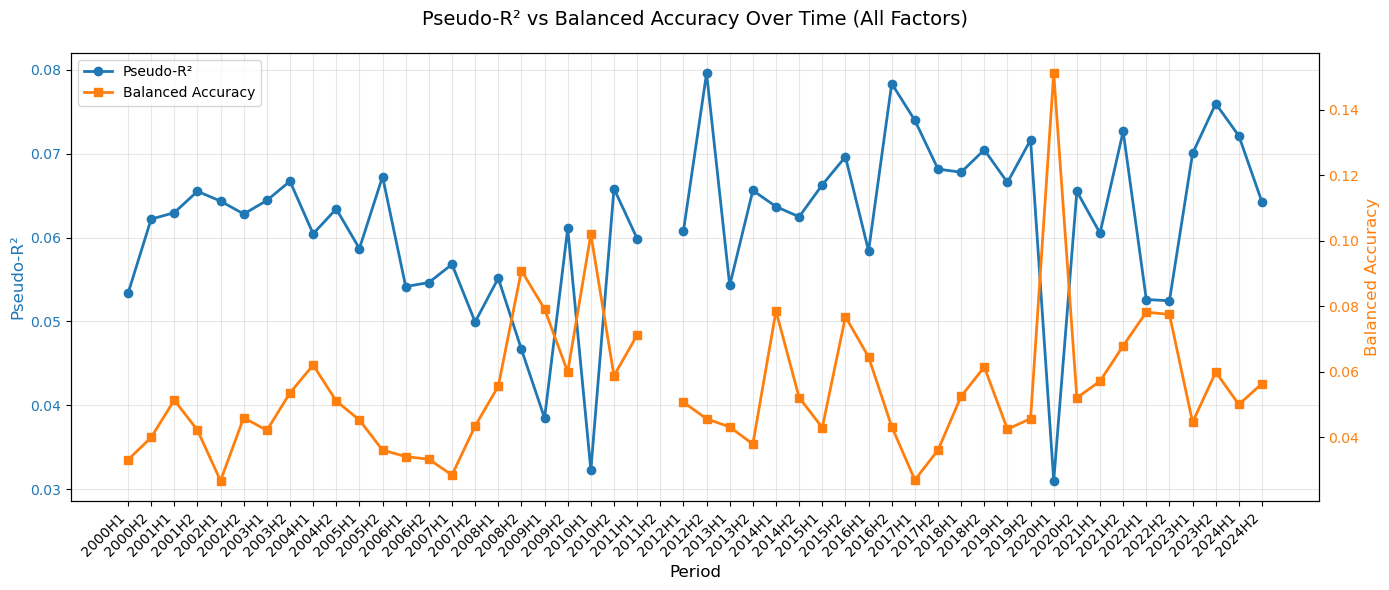

In [ ]:
# Prepare data - focus on the "all" model
all_model = res_df[res_df['model'] == 'all'].copy()

# Create figure with two y-axes
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot pseudo-R² on left axis
color = 'tab:blue'
ax1.set_xlabel('Period', fontsize=12)
ax1.set_ylabel('Pseudo-R²', color=color, fontsize=12)
ax1.plot(all_model['period'], all_model['pseudoR2'], 
         color=color, marker='o', linewidth=2, markersize=6, label='Pseudo-R²')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)

# Create second y-axis for balanced accuracy
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Balanced Accuracy', color=color, fontsize=12)
ax2.plot(all_model['period'], all_model['balanced_acc'], 
         color=color, marker='s', linewidth=2, markersize=6, label='Balanced Accuracy')
ax2.tick_params(axis='y', labelcolor=color)

# Rotate x-axis labels
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Title
plt.title('Pseudo-R² vs Balanced Accuracy Over Time (All Factors)', fontsize=14, pad=20)

# Add legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()

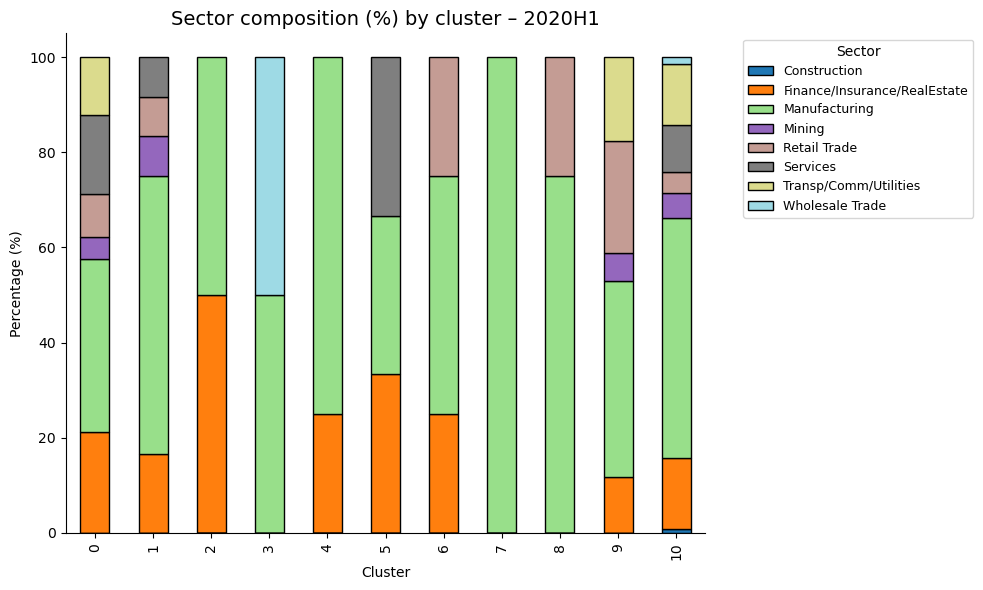

In [68]:
period = "2008H2"
df_2020H1 = period_stock[period_stock["period"] == period]

sector_pct = (
    df_2020H1
    .groupby(["cluster", "sector"])
    .size()                                   # count per (cluster, sector)
    .groupby("cluster", group_keys=False)     # re-group by cluster only
    .apply(lambda x: 100 * x / x.sum())       # convert to percent
    .reset_index(name="pct")
)

# Pivot so sectors become columns
pivot_df = sector_pct.pivot(index="cluster", columns="sector", values="pct")

# Sort clusters by ID (optional)
pivot_df = pivot_df.sort_index()

# Create stacked bar plot
ax = pivot_df.plot(
    kind="bar",
    stacked=True,
    figsize=(10, 6),
    colormap="tab20",   # or try "Set3" / "Paired" for clearer colors
    edgecolor="black"
)

plt.title("Sector composition (%) by cluster – 2020H1", fontsize=14)
plt.ylabel("Percentage (%)")
plt.xlabel("Cluster")
plt.legend(
    title="Sector",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    fontsize=9
)
sns.despine()
plt.tight_layout()
plt.show()

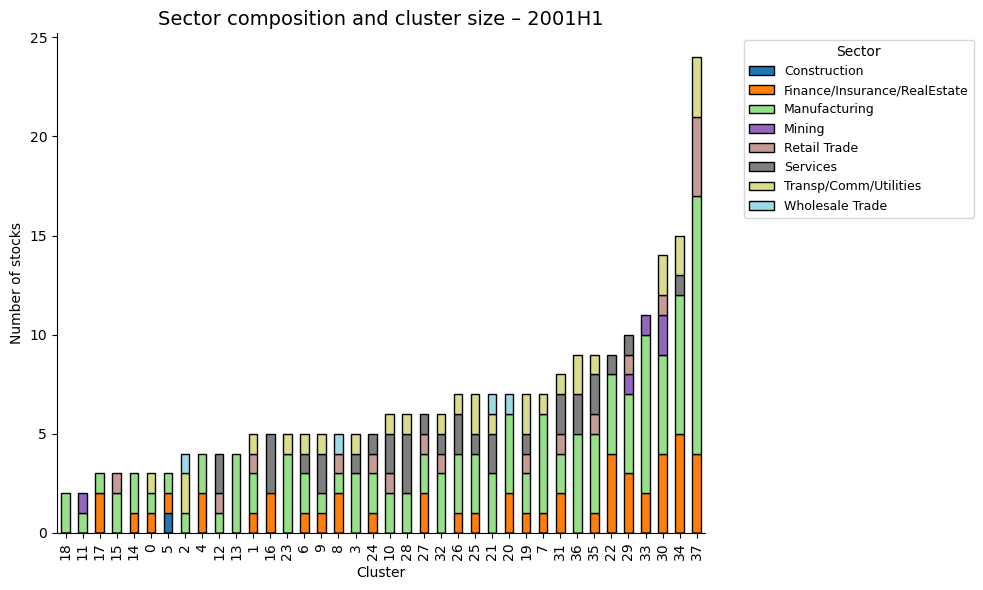

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns

period = "2001H1"

# subset data
df_period = period_stock[period_stock["period"] == period]

# compute sector counts per cluster
sector_counts = (
    df_period
    .groupby(["cluster", "sector"])
    .size()
    .reset_index(name="n_stocks")
)

# total cluster size
cluster_sizes = (
    df_period.groupby("cluster")
    .size()
    .reset_index(name="cluster_size")
)

# merge cluster size back to get proportions + absolute levels
sector_pct = sector_counts.merge(cluster_sizes, on="cluster")
sector_pct["pct"] = 100 * sector_pct["n_stocks"] / sector_pct["cluster_size"]

# pivot to get stacked bar structure, using *absolute counts* or *scaled percentage*
pivot_df = sector_counts.pivot(index="cluster", columns="sector", values="n_stocks").fillna(0)

# optionally sort clusters by size
pivot_df = pivot_df.loc[cluster_sizes.sort_values("cluster_size")["cluster"]]

# plot stacked bars where bar height = cluster size
ax = pivot_df.plot(
    kind="bar",
    stacked=True,
    figsize=(10, 6),
    colormap="tab20",
    edgecolor="black"
)

# titles and labels
plt.title(f"Sector composition and cluster size – {period}", fontsize=14)
plt.ylabel("Number of stocks")
plt.xlabel("Cluster")

# legend
plt.legend(
    title="Sector",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    fontsize=9
)
sns.despine()
plt.tight_layout()
plt.show()

In [27]:
summary = (
    period_stock.groupby(["period", "cluster"])
      .agg({
          "market_cap_median": ["mean", "median"],
          "vol_mean": ["mean", "median"],
          "sector": lambda x: x.value_counts(normalize=True).head(3)  # top 3 sectors shares
      })
)
print(summary)

               market_cap_median                    vol_mean                \
                            mean        median          mean        median   
period cluster                                                               
2000H1 0            1.933555e+09  4.635223e+08  9.158988e+05  2.430207e+05   
       1            4.402756e+08  2.611075e+08  6.826682e+05  2.566204e+05   
       2            4.024625e+08  2.732803e+08  3.177326e+05  2.461713e+05   
       3            4.709529e+09  2.571297e+09  2.070025e+06  1.621118e+06   
       4            5.979372e+08  2.513440e+08  2.905683e+05  2.460742e+05   
...                          ...           ...           ...           ...   
2024H2 28           6.257345e+09  6.106321e+09  4.812284e+06  7.619589e+05   
       29           1.577026e+10  4.717145e+08  6.567580e+06  1.114643e+06   
       30           2.208870e+10  4.967692e+09  6.613683e+06  1.600187e+06   
       31           3.585043e+09  7.494908e+08  6.710689e+05  5.